In [1]:
from collections import Counter
from pathlib import Path
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

from ihop.community2vec import GensimCommunity2Vec
import ihop.clustering as ic

sns.set_palette("Dark2")

In [2]:
DATA_ROOT = Path("../data")
C2V_ROOT = DATA_ROOT / "community2vec"

# Output path, save models as you go for convenience
MODEL_COMPARISON_ROOT = DATA_ROOT / "kmeans_vs_agglomerative"

N_CLUSTERS = [5, 10, 50, 100, 175, 250, 400]

MONTHS = sorted(["2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10", "2021-11", "2021-12", "2022-01", "2022-02", "2022-03"
])

C2V_MODELS = [GensimCommunity2Vec.load(C2V_ROOT / f"RC_{m}"/"best_model") for m in MONTHS]

#Recall that cosine distance and euclidean distance are equivalent with normed vectors, which is what Gensim returns
CLUSTER_MODEL_SETTINGS = [
    ("kmeans", {"model_choice":"kmeans", "n_clusters":N_CLUSTERS, "random_state":97}),
    ("ward_agglomerative", {"model_choice":"agglomerative", "linkage":"ward", "n_clusters":N_CLUSTERS, "affinity":"euclidean"}),
    ("average_agglomerative", {"model_choice":"agglomerative", "linkage":"average", "affinity":"euclidean", "n_clusters":N_CLUSTERS}),
    ("complete_agglomerative", {"model_choice":"agglomerative", "linkage":"complete", "affinity":"euclidean", "n_clusters":N_CLUSTERS})
]


# Goal
The goal of this notebook is to quantitatively capture the differences in clustering between clusters of subreddits created using KMeans vs those created using hierarchical agglomerative clustering from the same underlying community2vec models in terms of:
- Variation of cluster size (how many subreddits assigned to each cluster)
- Silhouette Coefficient: Ranges between -1 (clustering is totally incorrect) and 1 (clusters are dense and well separated), scores around 0 indicate overlapping clusters.  
- Calinski-Harabasz Index: Higher for models with clusters that are dense and well separated.
- Davies-Bouldin Index: Measures separation/similarity between clusters by taking ratio of within-cluster distances to between-cluster distances. The minimum is zero, lower scores indicate better separation

# Train and Save Models
For each month, train a Kmeans model, then the 3 agglomerative cluster models with different settings. 

In [3]:
metrics_collection =[]
for nc in N_CLUSTERS:
    print("Number clusters:", nc)
    for month, c2v_model in zip(MONTHS, C2V_MODELS):
        print("\tProcessing", month)
        vectors = c2v_model.w2v_model.wv
        data = c2v_model.get_normed_vectors()
        index = dict(enumerate(vectors.index_to_key))
        for label, model_params in CLUSTER_MODEL_SETTINGS:
            curr_model_path = MODEL_COMPARISON_ROOT / month / str(nc) / label
            #Clear any existing model
            if curr_model_path.exists() and curr_model_path.is_dir():
                shutil.rmtree(curr_model_path)
            curr_model_path.mkdir(parents=True)
            params = model_params.copy()
            params["n_clusters"] = nc
            model_name = f"{month}_{label}"
            curr_model = ic.ClusteringModelFactory.init_clustering_model(model_choice=params.pop("model_choice"), data=data, index=index, model_name=model_name, **params)
            curr_model.train()
            curr_model.save(curr_model_path)
            curr_model.get_cluster_results_as_df().to_csv(curr_model_path / "clusters.csv", index=False)

            metrics = curr_model.write_metrics((curr_model_path / "metrics.json"))
            cluster_size_counts = list(Counter(curr_model.clusters).values())
            # Cluster size mean is just for sanity check, it should alwasy be 100
            mean = np.mean(cluster_size_counts)
            std_dev = np.std(cluster_size_counts)
            metrics["cluster_size_mean"] = mean
            metrics["cluster_size_stddev"] = std_dev
            metrics["month"] = month
            metrics["experiment_label"] = label
            metrics["n_clusters"] = nc

            metrics_collection.append(metrics)

model_metrics_df = pd.DataFrame.from_records(metrics_collection)

Number clusters: 5
	Processing 2021-04
	Processing 2021-05
	Processing 2021-06
	Processing 2021-07
	Processing 2021-08
	Processing 2021-09
	Processing 2021-10
	Processing 2021-11
	Processing 2021-12
	Processing 2022-01
	Processing 2022-02
	Processing 2022-03
Number clusters: 10
	Processing 2021-04
	Processing 2021-05
	Processing 2021-06
	Processing 2021-07
	Processing 2021-08
	Processing 2021-09
	Processing 2021-10
	Processing 2021-11
	Processing 2021-12
	Processing 2022-01
	Processing 2022-02
	Processing 2022-03
Number clusters: 50
	Processing 2021-04
	Processing 2021-05
	Processing 2021-06
	Processing 2021-07
	Processing 2021-08
	Processing 2021-09
	Processing 2021-10
	Processing 2021-11
	Processing 2021-12
	Processing 2022-01
	Processing 2022-02
	Processing 2022-03
Number clusters: 100
	Processing 2021-04
	Processing 2021-05
	Processing 2021-06
	Processing 2021-07
	Processing 2021-08
	Processing 2021-09
	Processing 2021-10
	Processing 2021-11
	Processing 2021-12
	Processing 2022-01


In [4]:
model_metrics_df

,Silhouette,Calinski-Harabasz,Davies-Bouldin,cluster_size_mean,cluster_size_stddev,month,experiment_label,n_clusters
0,0.098049,363.381135,4.210094,2000.0,425.568796,2021-04,kmeans,5
1,0.073981,292.093144,5.068465,2000.0,472.649130,2021-04,ward_agglomerative,5
2,0.174184,2.613877,2.032014,2000.0,3994.000150,2021-04,average_agglomerative,5
3,0.036964,151.540229,3.888845,2000.0,2529.974308,2021-04,complete_agglomerative,5
4,0.103241,371.054839,4.119707,2000.0,381.650102,2021-05,kmeans,5
...,...,...,...,...,...,...,...,...
331,0.096706,19.005709,2.598527,25.0,30.166538,2022-02,complete_agglomerative,400
332,0.113706,22.379574,2.675682,25.0,13.902158,2022-03,kmeans,400
333,0.104283,22.203095,2.586345,25.0,15.289212,2022-03,ward_agglomerative,400
334,0.096980,16.071067,1.956953,25.0,75.263271,2022-03,average_agglomerative,400


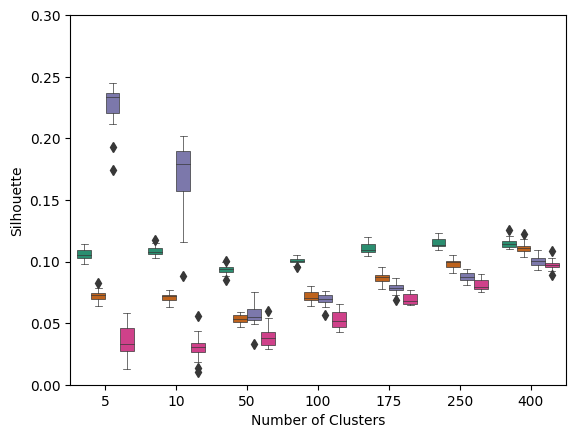

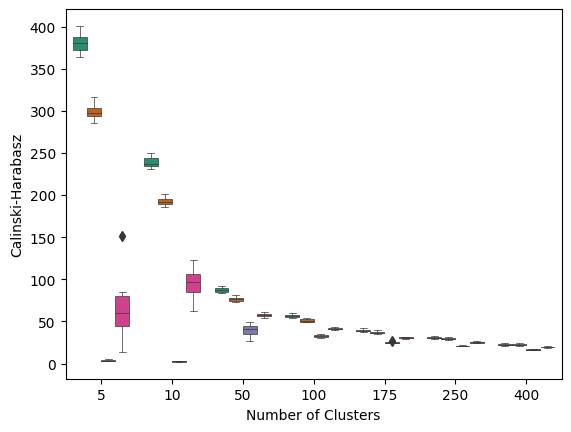

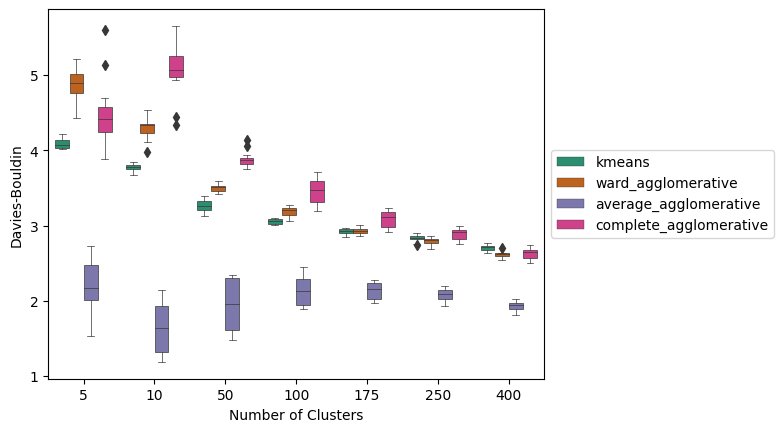

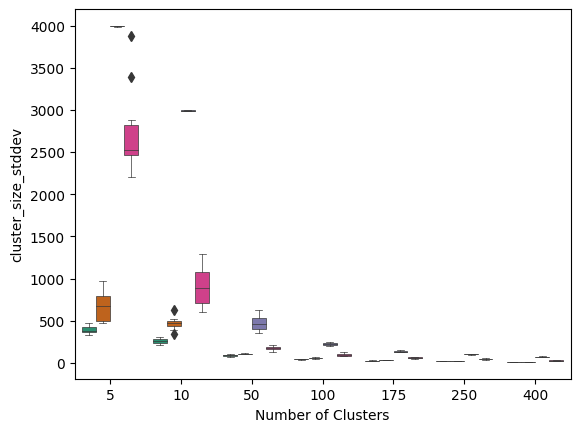

<Figure size 640x480 with 0 Axes>

In [5]:
for metric_key in ["Silhouette", "Calinski-Harabasz", "Davies-Bouldin", "cluster_size_stddev"]:
    ax = sns.boxplot( y=metric_key, x="n_clusters", data=model_metrics_df, hue="experiment_label", linewidth=0.5)
    #ax.set_title(f"{metric_key} score averaged across a year of monthly snapshot clustering models")
    ax.set(xlabel="Number of Clusters")
    if metric_key=="Silhouette":
        ax.set(ylim=(0.0, 0.3))
    if metric_key=="Davies-Bouldin":
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    else:
        ax.get_legend().remove()
        
    plt.show()
    plt.clf()

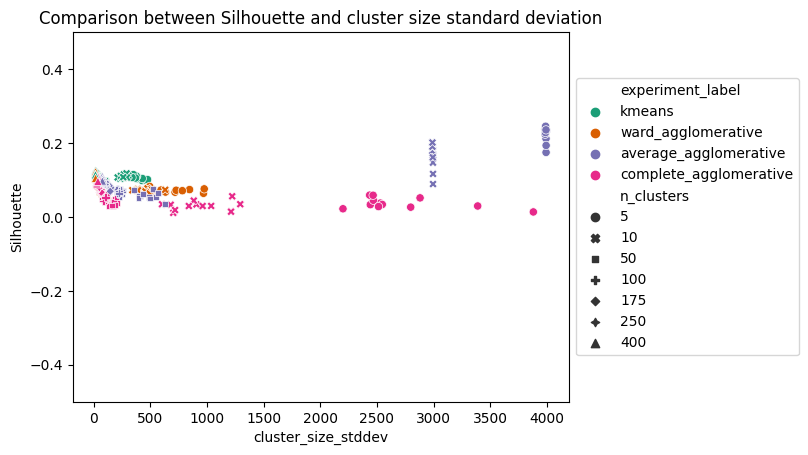

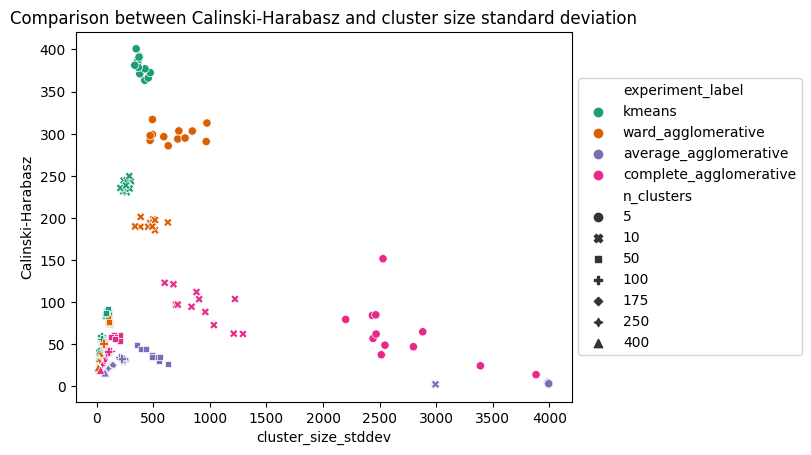

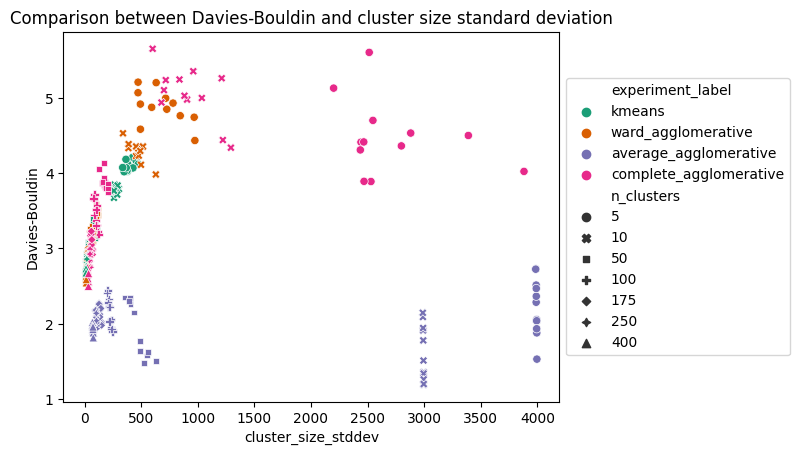

<Figure size 640x480 with 0 Axes>

In [6]:

for metric_key in ["Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]:
    ax = sns.scatterplot(y=metric_key, x="cluster_size_stddev", data=model_metrics_df, hue="experiment_label", style="n_clusters", linewidth=0.5)
    ax.set_title(f"Comparison between {metric_key} and cluster size standard deviation")
    if metric_key=="Silhouette":
        ax.set(ylim=(-0.5, 0.5))
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.clf()

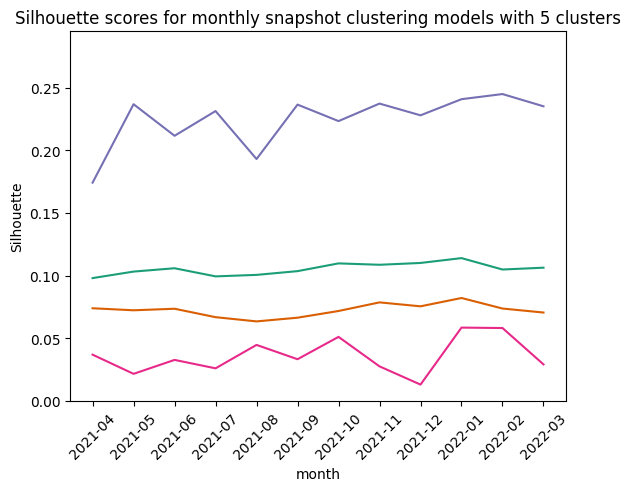

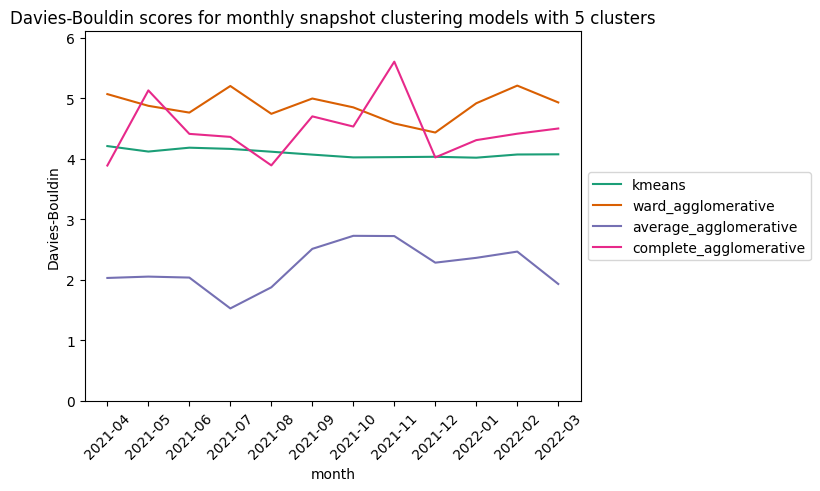

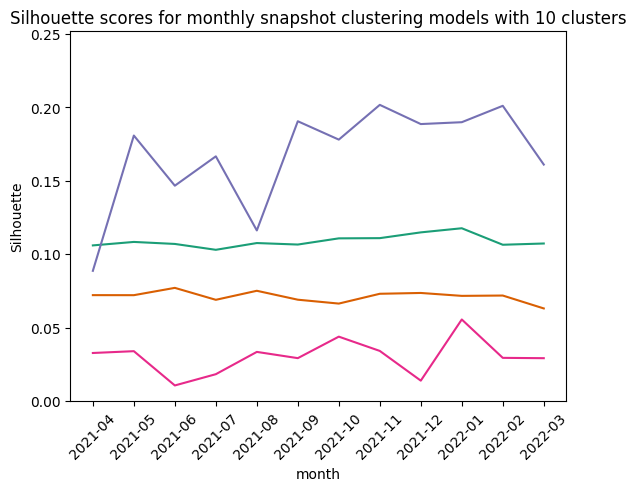

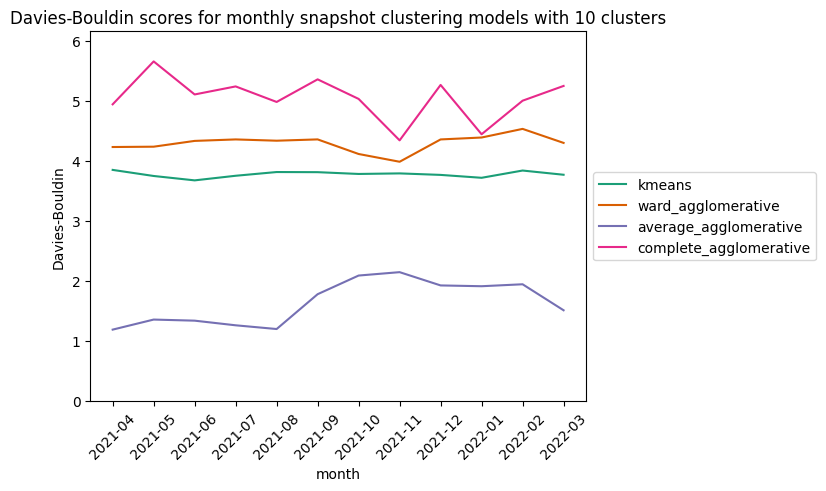

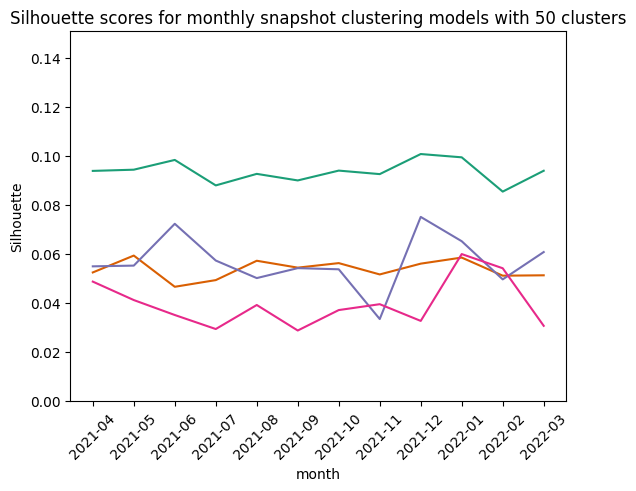

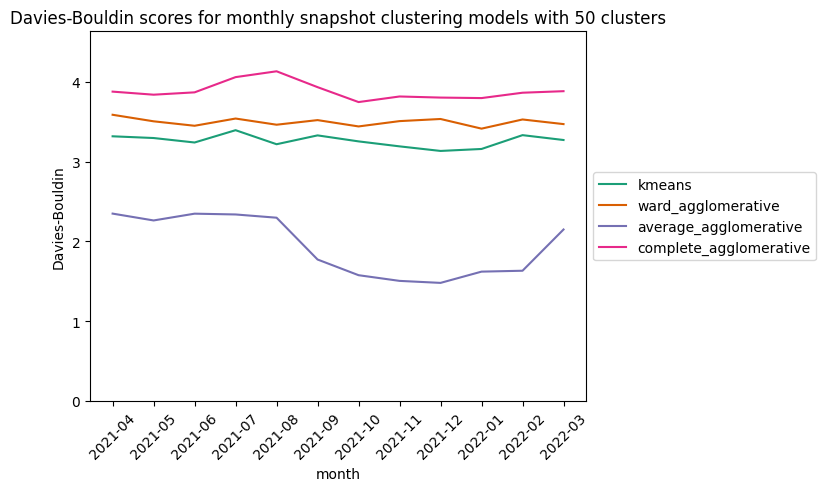

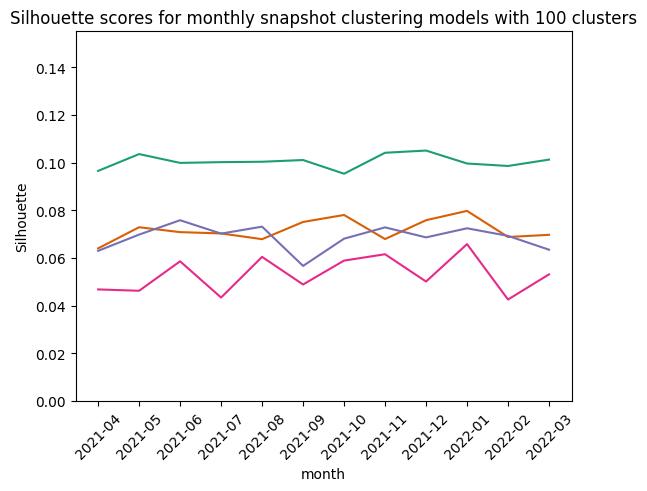

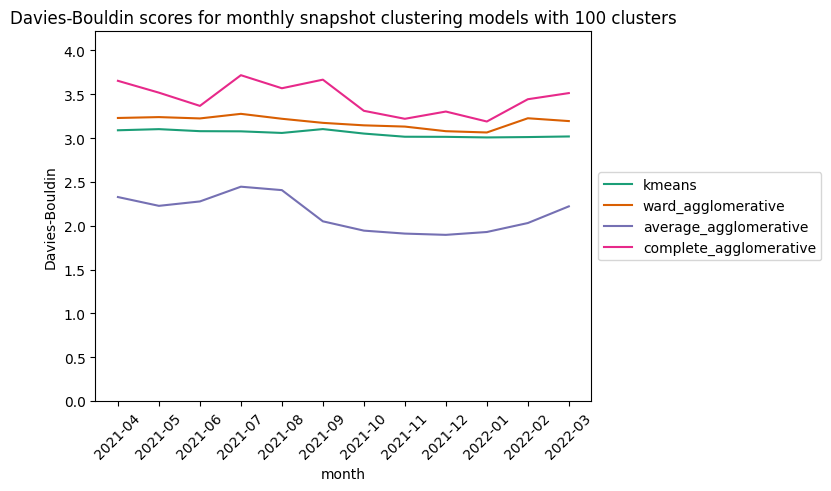

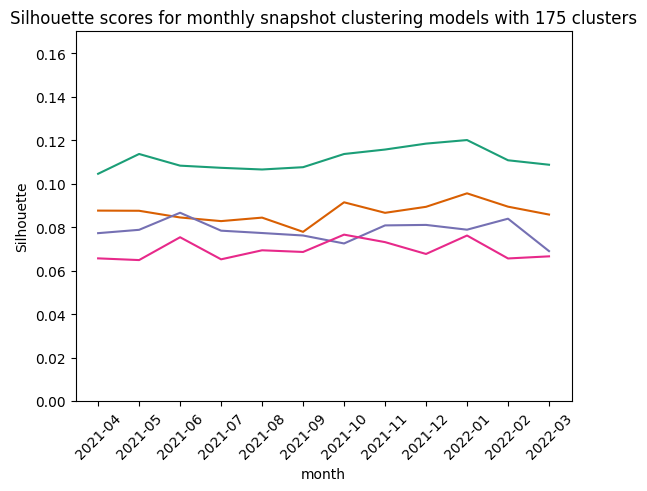

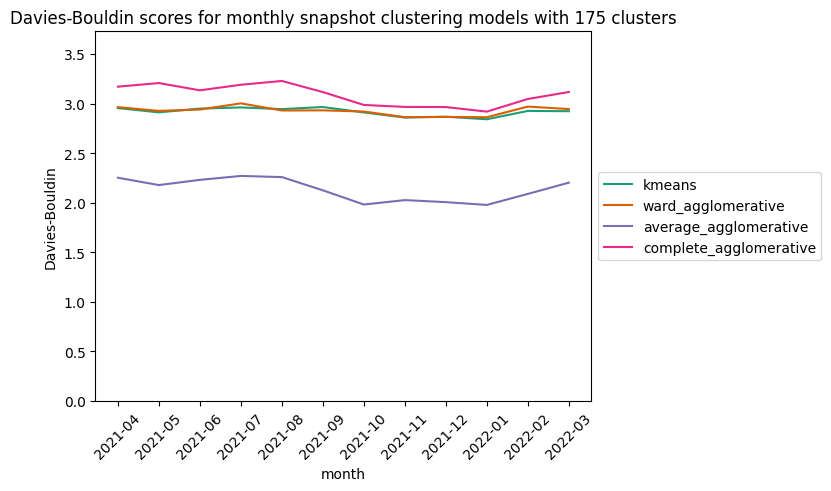

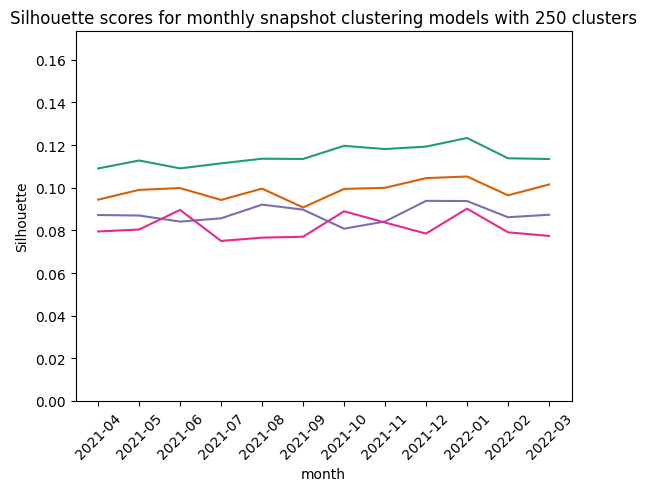

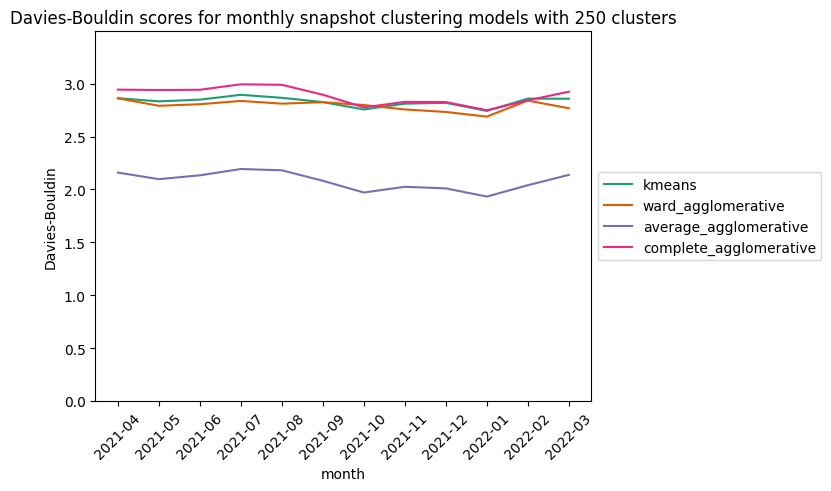

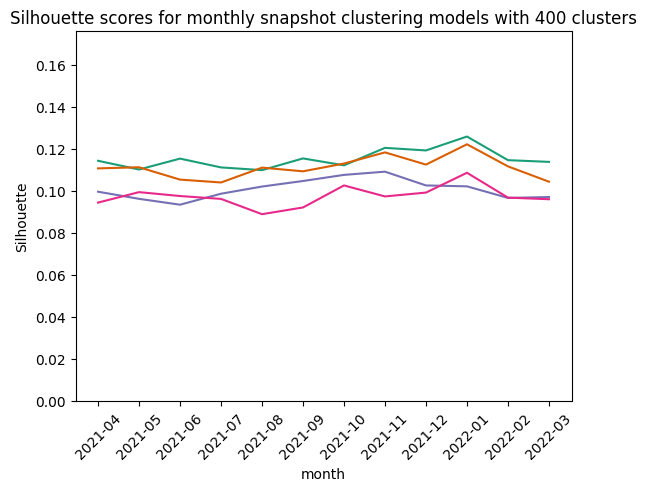

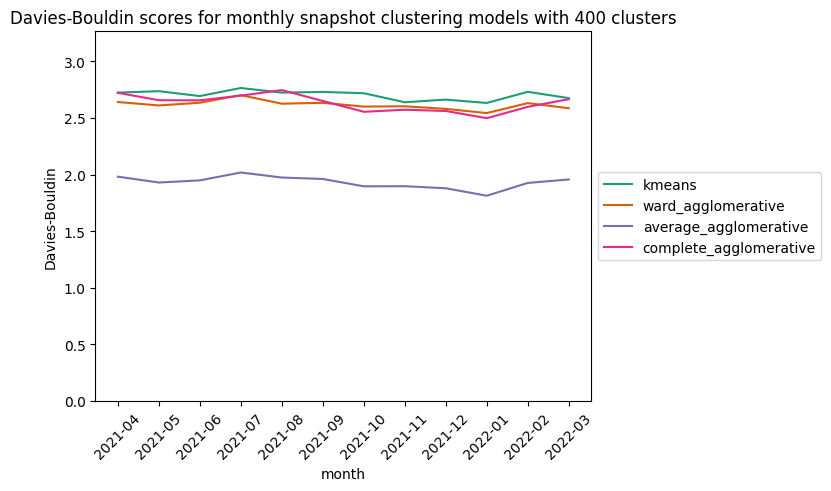

<Figure size 640x480 with 0 Axes>

In [24]:
for n in N_CLUSTERS:
    tmp_n_cluster_models = model_metrics_df[model_metrics_df["n_clusters"] == n]
    for metric_key in ["Silhouette", "Davies-Bouldin"]:
        ax = sns.lineplot(y=metric_key, x="month", data=tmp_n_cluster_models, hue="experiment_label")
        ax.set_title(f"{metric_key} scores for monthly snapshot clustering models with {n} clusters")
        plt.xticks(rotation=45)
        if metric_key == "Silhouette":
            ax.set(ylim=(0, tmp_n_cluster_models[metric_key].max() + .05))
            ax.legend().remove()
        else:
            ax.set(ylim=(0, tmp_n_cluster_models[metric_key].max() + .5))
            plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.show()
        plt.clf()